<a href="https://colab.research.google.com/github/edilmerchn/DIAGNOSTICO-DE-RECURRENCIA-DEL-CANCER-DE-MAMA-MEDIANTE-APRENDIZAJE-AUTOMATICO/blob/main/Proyecto_aprendizaje_automatico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Líbrerias

In [ ]:
!pip install ucimlrepo

In [ ]:
#importamos librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#Data visualization

In [ ]:
# Cargar el dataset directo desde el repositorio
breast_cancer = fetch_ucirepo(id=14)

X = breast_cancer.data.features
y = breast_cancer.data.targets

# Unir ambos en un solo DataFrame para facilitar análisis
df = pd.concat([X, y], axis=1)

In [ ]:
# Información general
print(df.info())
print("\n******************************************************\n")
# Estadísticas descriptivas
print(df.describe())
print("\n******************************************************\n")
print(df.count())
print("\n******************************************************\n")
# Vista previa de los datos
print(f"cantidad de datos: {len(df)}")
print("\n******************************************************\n")
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          286 non-null    object
 1   menopause    286 non-null    object
 2   tumor-size   286 non-null    object
 3   inv-nodes    286 non-null    object
 4   node-caps    278 non-null    object
 5   deg-malig    286 non-null    int64 
 6   breast       286 non-null    object
 7   breast-quad  285 non-null    object
 8   irradiat     286 non-null    object
 9   Class        286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB
None

******************************************************

        deg-malig
count  286.000000
mean     2.048951
std      0.738217
min      1.000000
25%      2.000000
50%      2.000000
75%      3.000000
max      3.000000

******************************************************

age            286
menopause      286
tumor-size     286
inv-nodes     

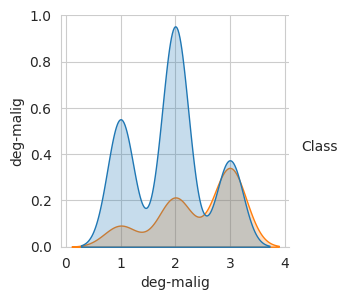

In [ ]:
plt.close();
sns.set_style("whitegrid");
sns.pairplot(df, hue="Class", height=3);
plt.show()

<ipython-input-6-7bc98df2b14f>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y=col, data=df, palette='Set3')


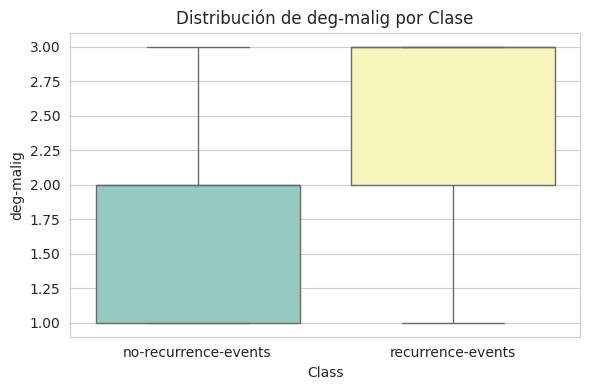

In [ ]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
#Boxplots por clase para ver diferencias y outliers
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Class', y=col, data=df, palette='Set3')
    plt.title(f'Distribución de {col} por Clase')
    plt.tight_layout()
    plt.show()

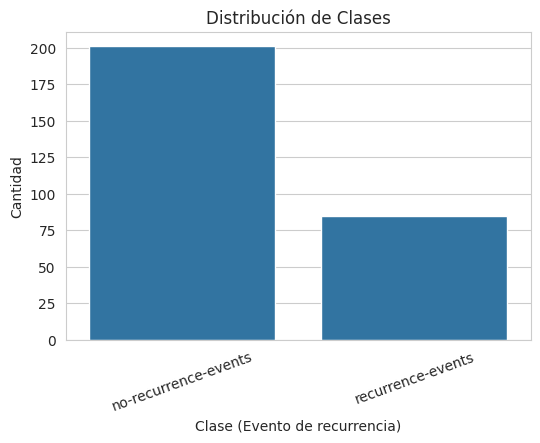

In [ ]:
# 2. Conteo por clase
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Class')
plt.title('Distribución de Clases')
plt.xlabel('Clase (Evento de recurrencia)')
plt.ylabel('Cantidad')
plt.xticks(rotation=20)
plt.show()

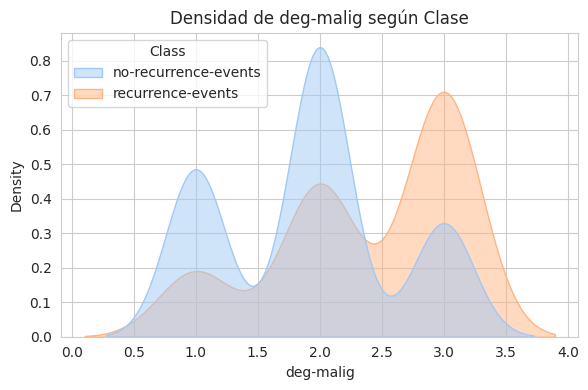

In [ ]:
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=df, x=col, hue='Class', fill=True, common_norm=False, palette='pastel', alpha=0.5)
    plt.title(f'Densidad de {col} según Clase')
    plt.tight_layout()
    plt.show()

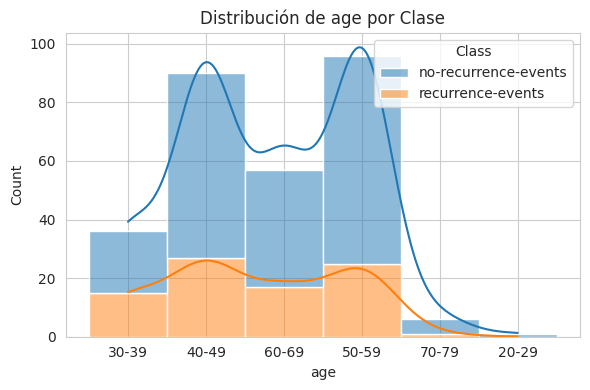

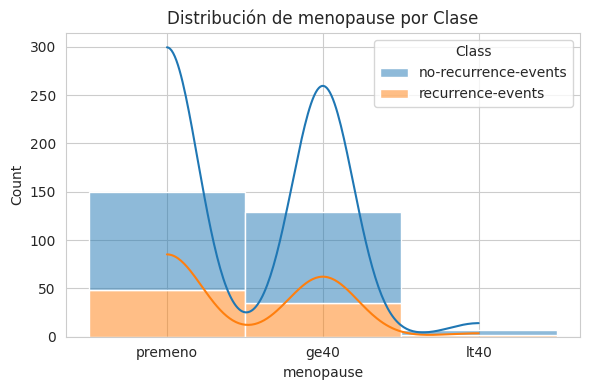

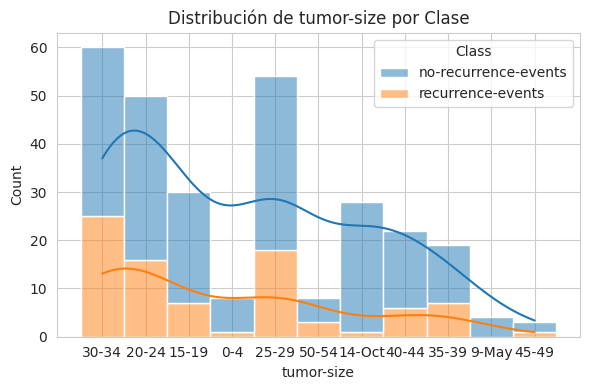

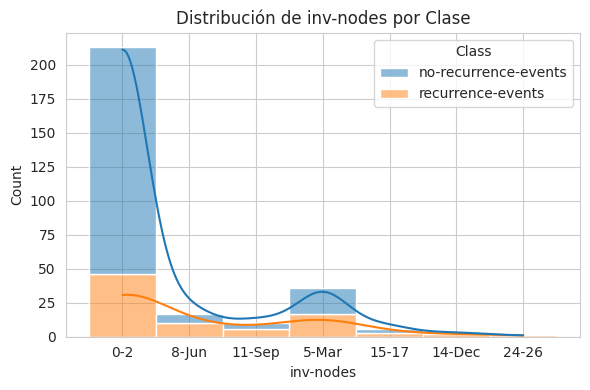

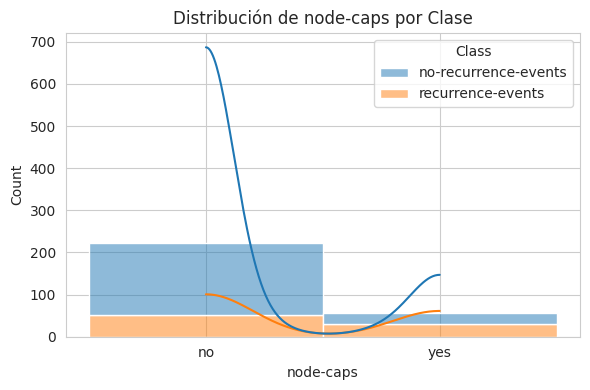

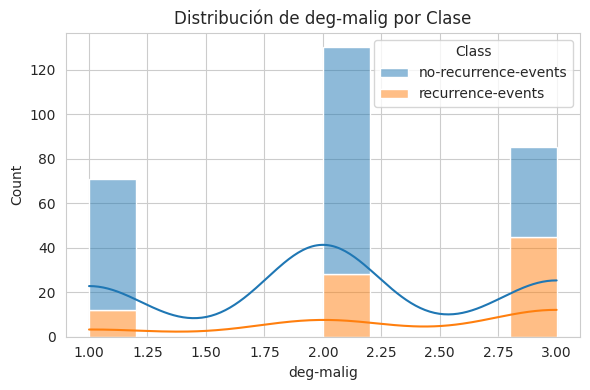

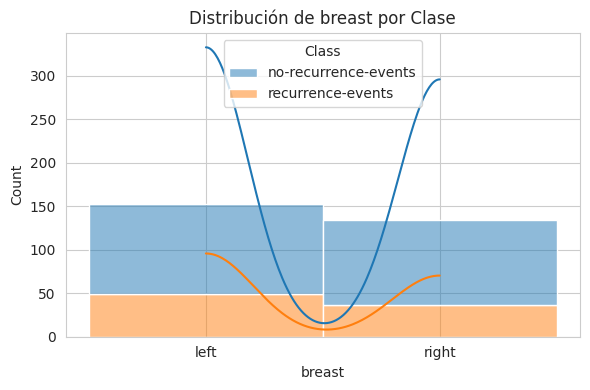

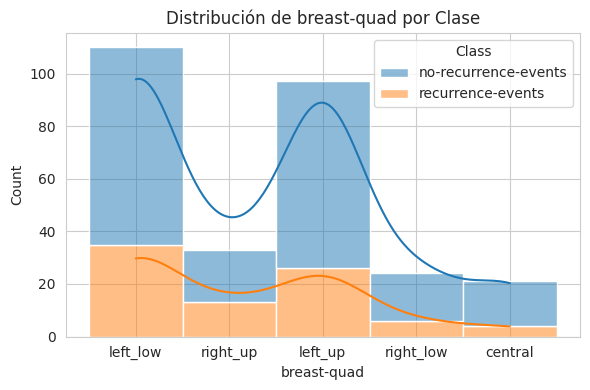

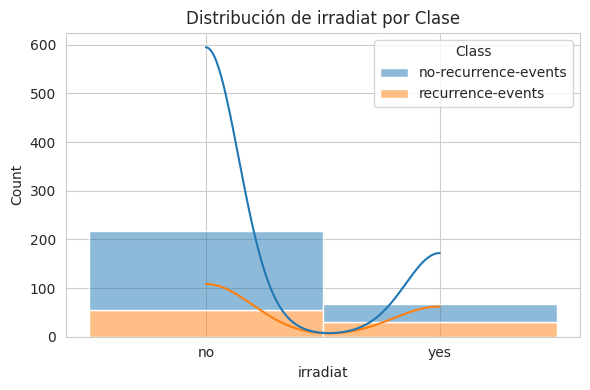

In [ ]:
# 3. Histogramas por clase
for column in df.columns[:-1]:  # omitimos la columna 'Class'
    plt.figure(figsize=(6,4))
    sns.histplot(data=df, x=column, hue='Class', kde=True, multiple='stack')
    plt.title(f'Distribución de {column} por Clase')
    plt.tight_layout()
    plt.show()

#Dataset preprocessing

In [ ]:
# Eliminación de registros con datos faltantes
df_clean = df.dropna()
print(df_clean.isnull().sum())

age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiat       0
Class          0
dtype: int64


In [ ]:
df_clean.count()

,0
age,277
menopause,277
tumor-size,277
inv-nodes,277
node-caps,277
deg-malig,277
breast,277
breast-quad,277
irradiat,277
Class,277


In [ ]:
#Codificar columnas binarias con LabelEncoder
binary_cols = ['node-caps', 'breast', 'irradiat', 'Class']
le = LabelEncoder()
for col in binary_cols:
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))

<ipython-input-12-89dc5757be99>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = le.fit_transform(df_clean[col].astype(str))
<ipython-input-12-89dc5757be99>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = le.fit_transform(df_clean[col].astype(str))
<ipython-input-12-89dc5757be99>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [ ]:
#Codificar categóricas no ordinales con OneHotEncoder
categorical_cols = ['age', 'menopause', 'tumor-size', 'inv-nodes', 'breast-quad']

# Usamos get_dummies (más simple aquí que usar OneHotEncoder manualmente)
df_clean = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)


In [ ]:
df_clean[df_clean.select_dtypes('bool').columns] = df_clean.select_dtypes('bool').astype(int)
# Mover 'Class' a la última posición
class_column = df_clean['Class']
df_clean = df_clean.drop('Class', axis=1)
df_clean['Class'] = class_column


In [ ]:
df_clean.head()

,node-caps,deg-malig,breast,irradiat,age_30-39,age_40-49,age_50-59,age_60-69,age_70-79,menopause_lt40,...,inv-nodes_14-Dec,inv-nodes_15-17,inv-nodes_24-26,inv-nodes_5-Mar,inv-nodes_8-Jun,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up,Class
0,0,3,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,2,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,2,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,2,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277 entries, 0 to 285
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   node-caps              277 non-null    int64
 1   deg-malig              277 non-null    int64
 2   breast                 277 non-null    int64
 3   irradiat               277 non-null    int64
 4   age_30-39              277 non-null    int64
 5   age_40-49              277 non-null    int64
 6   age_50-59              277 non-null    int64
 7   age_60-69              277 non-null    int64
 8   age_70-79              277 non-null    int64
 9   menopause_lt40         277 non-null    int64
 10  menopause_premeno      277 non-null    int64
 11  tumor-size_14-Oct      277 non-null    int64
 12  tumor-size_15-19       277 non-null    int64
 13  tumor-size_20-24       277 non-null    int64
 14  tumor-size_25-29       277 non-null    int64
 15  tumor-size_30-34       277 non-null    int64


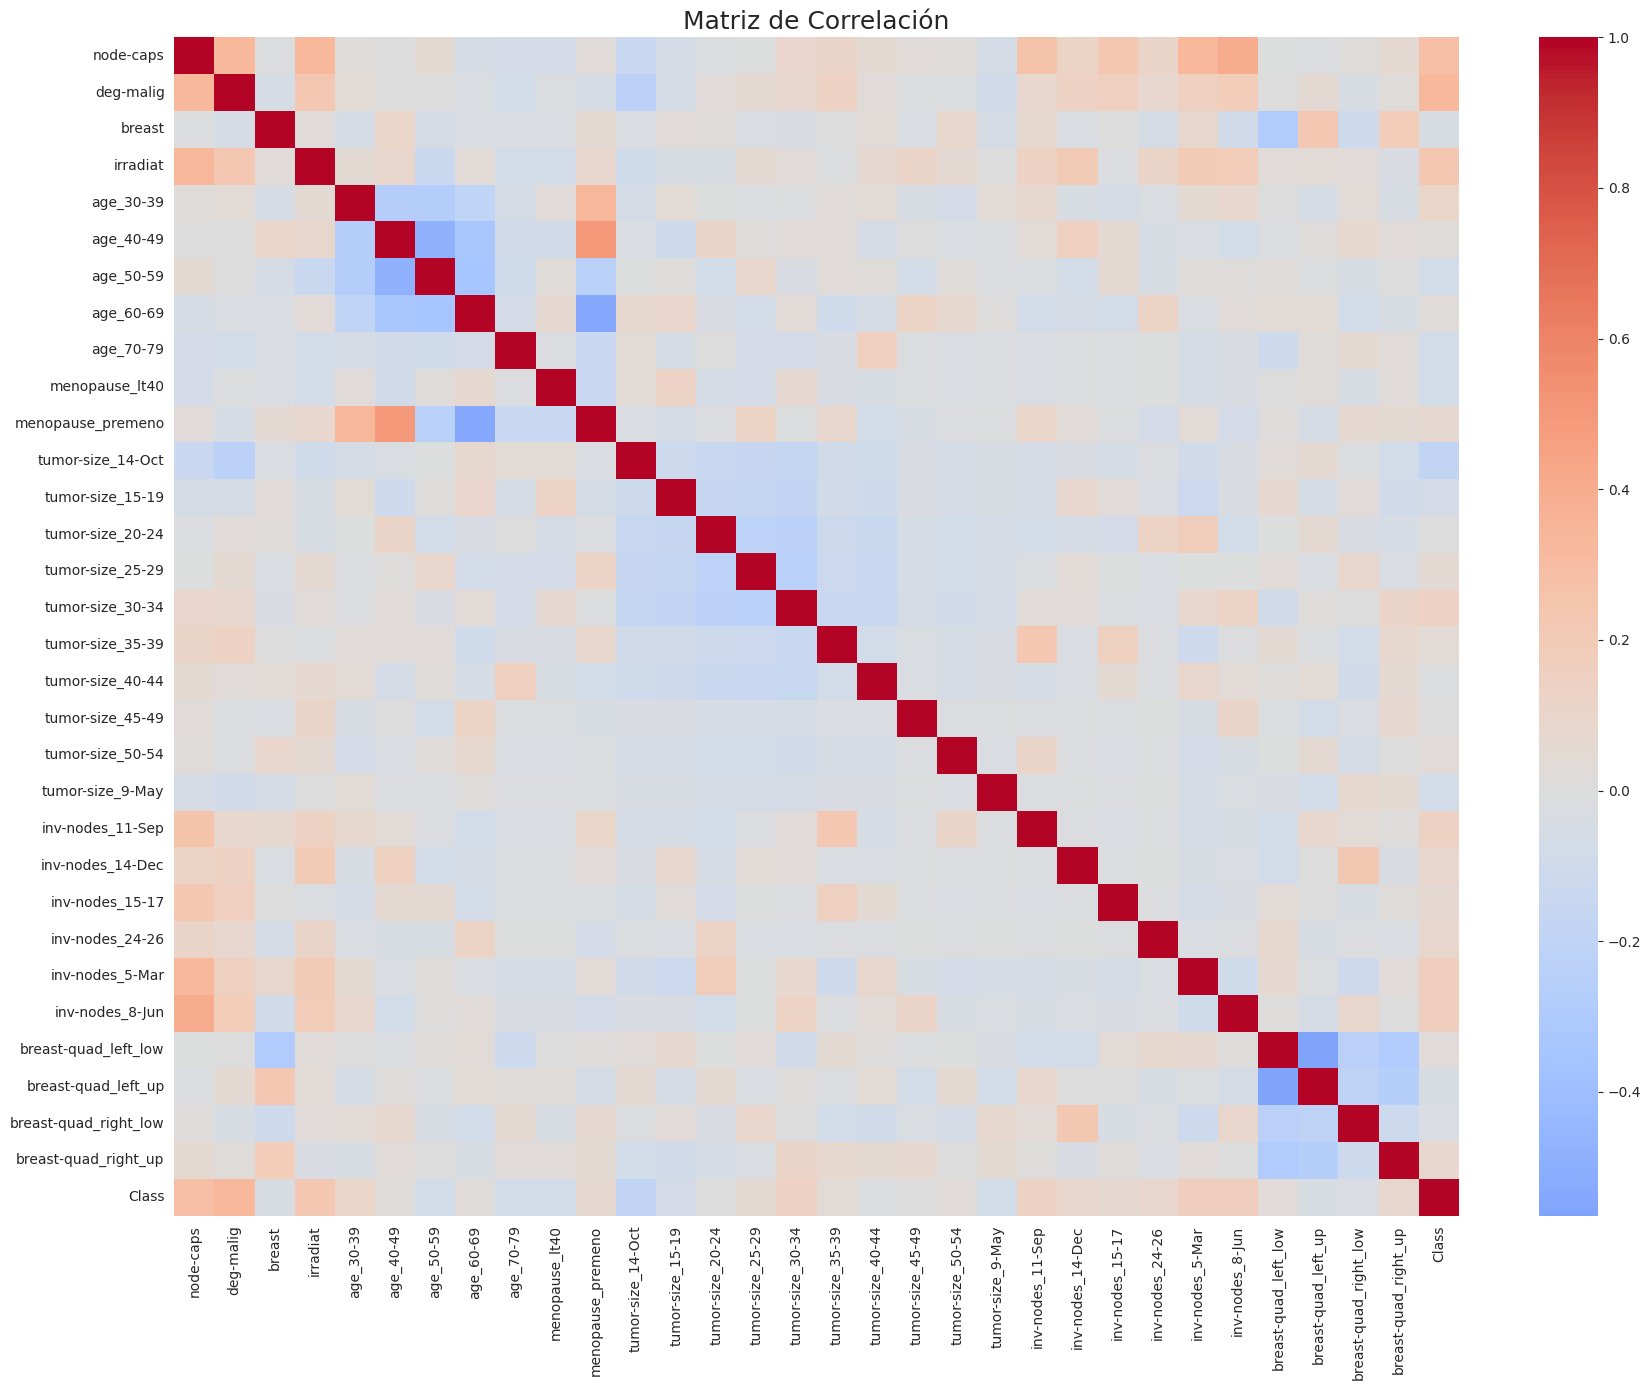

In [ ]:
# 1. Calcular la matriz de correlación
correlation_matrix = df_clean.corr()

# 2. Dibujar el heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, center=0)
plt.title('Matriz de Correlación', fontsize=18)
plt.tight_layout()
plt.show()

#Visualizaciones con dataset procesado

In [ ]:
df_clean.head(5)


,node-caps,deg-malig,breast,irradiat,age_30-39,age_40-49,age_50-59,age_60-69,age_70-79,menopause_lt40,...,inv-nodes_14-Dec,inv-nodes_15-17,inv-nodes_24-26,inv-nodes_5-Mar,inv-nodes_8-Jun,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up,Class
0,0,3,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,2,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,2,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,2,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Suponiendo que tu dataset está en un DataFrame llamado df
X = df_clean.drop(columns=['Class'])
y = df_clean['Class']

In [ ]:
X.tail(5)                        # To display the botton 5 rows

,node-caps,deg-malig,breast,irradiat,age_30-39,age_40-49,age_50-59,age_60-69,age_70-79,menopause_lt40,...,inv-nodes_11-Sep,inv-nodes_14-Dec,inv-nodes_15-17,inv-nodes_24-26,inv-nodes_5-Mar,inv-nodes_8-Jun,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up
281,0,2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
282,0,3,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
283,0,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
284,0,3,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
285,0,3,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [ ]:
y.tail(5)

,Class
281,1
282,1
283,1
284,1
285,1


In [ ]:
X.describe()

,node-caps,deg-malig,breast,irradiat,age_30-39,age_40-49,age_50-59,age_60-69,age_70-79,menopause_lt40,...,inv-nodes_11-Sep,inv-nodes_14-Dec,inv-nodes_15-17,inv-nodes_24-26,inv-nodes_5-Mar,inv-nodes_8-Jun,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up
count,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,...,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000
mean,0.202166,2.057762,0.476534,0.223827,0.129964,0.321300,0.328520,0.198556,0.018051,0.018051,...,0.025271,0.010830,0.021661,0.003610,0.122744,0.061372,0.382671,0.339350,0.083032,0.119134
std,0.402342,0.729989,0.500353,0.417562,0.336872,0.467821,0.470525,0.399635,0.133375,0.133375,...,0.157230,0.103691,0.145836,0.060084,0.328737,0.240446,0.486919,0.474346,0.276431,0.324532
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#Machine Learning Models

<h2>Split dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

#MODEL 1 (Logistic Regression)


Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.75      0.86      0.80        59
           1       0.50      0.32      0.39        25

    accuracy                           0.70        84
   macro avg       0.62      0.59      0.60        84
weighted avg       0.68      0.70      0.68        84



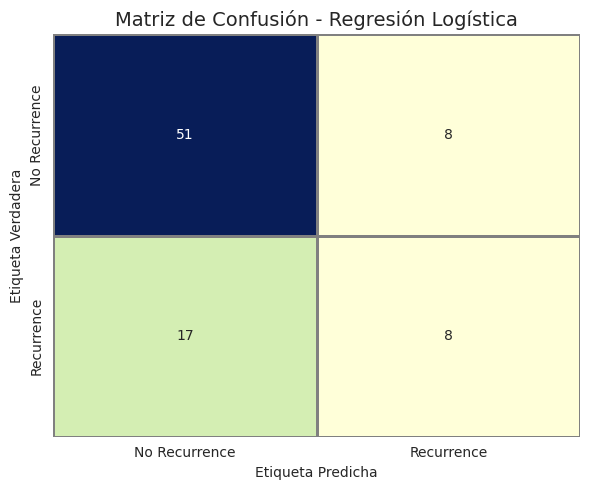

In [ ]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred_log = logreg.predict(X_test)

print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred_log))

cm = confusion_matrix(y_test, y_pred_log)
labels = ['No Recurrence', 'Recurrence']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels, cbar=False,
            linewidths=1, linecolor='gray')
plt.title('Matriz de Confusión - Regresión Logística', fontsize=14)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.tight_layout()
plt.show()

## Interpretación del modelo: Regresión Logística

### 1. Matriz de Confusión

|                  | Predicho: No Recurrence | Predicho: Recurrence |
|------------------|-------------------------|-----------------------|
| **Real: No Recurrence** | 51                      | 8                     |
| **Real: Recurrence**     | 17                      | 8                     |

- El modelo identifica correctamente 51 de 59 casos de **no recurrencia**.
- Sin embargo, solo detecta 8 de 25 casos de **recurrencia**, lo que es preocupante en un contexto médico.

---

### 2. Métricas clave (de clasificación)

- **Clase 0 (No Recurrence)**
  - Precision: 0.75
  - Recall: 0.86
  - F1-score: 0.80

- **Clase 1 (Recurrence)**
  - Precision: 0.50
  - Recall: 0.32
  - F1-score: 0.39

 *Conclusión*: El modelo es mucho más efectivo prediciendo la clase mayoritaria (no recurrencia) que la minoritaria (recurrencia). Tiene bajo recall en clase 1, lo que implica que muchos casos de recaída no están siendo detectados correctamente.

---

### 3. Exactitud general

- **Accuracy total**: 70%

Aunque este valor puede parecer aceptable, es **engañoso en un dataset desbalanceado**. El modelo podría acertar frecuentemente solo prediciendo la clase más común.

---

### 4. Análisis de complejidad del modelo

- Modelo **lineal**, simple, muy eficiente en entrenamiento.
- Fácilmente interpretable a través de los coeficientes.
- Puede estar presentando **underfitting**, al no capturar patrones complejos necesarios para identificar la clase minoritaria.

---


### Análisis de complejidad del modelo

El modelo de **regresión logística** tiene las siguientes características desde el punto de vista de complejidad:

- **Simplicidad computacional**: entrenamiento muy rápido, incluso con muchas variables. Ideal para modelos base.
- **Baja complejidad estructural**: no modela relaciones no lineales ni interacciones complejas entre variables.
- **Poco propenso a overfitting**, pero puede caer fácilmente en **underfitting** si los patrones en los datos son complejos.
- **Interpretabilidad alta**: los coeficientes indican directamente la influencia de cada variable.
- **Tamaño del modelo reducido**: ideal cuando se requiere trazabilidad y comprensión del modelo.

En resumen, es un modelo eficiente y transparente, pero limitado para capturar relaciones complejas o desequilibrios severos entre clases.


#MODEL 2 (Decision Tree)


 Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.76      0.81      0.79        59
           1       0.48      0.40      0.43        25

    accuracy                           0.69        84
   macro avg       0.62      0.61      0.61        84
weighted avg       0.68      0.69      0.68        84



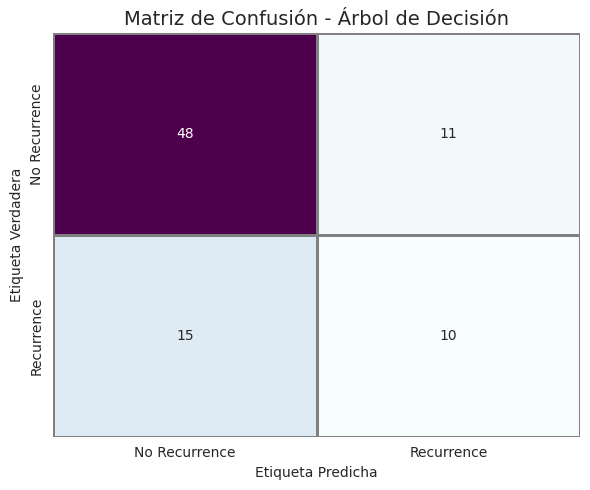

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

print("\n Reporte de Clasificación:\n", classification_report(y_test, y_pred_dt))

cm_dt = confusion_matrix(y_test, y_pred_dt)
labels = ['No Recurrence', 'Recurrence']

plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='BuPu',
            xticklabels=labels, yticklabels=labels, cbar=False,
            linewidths=1, linecolor='gray')
plt.title('Matriz de Confusión - Árbol de Decisión', fontsize=14)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.tight_layout()
plt.show()

## Interpretación del modelo: Árbol de Decisión

### 1. Matriz de Confusión

|                  | Predicho: No Recurrence | Predicho: Recurrence |
|------------------|-------------------------|-----------------------|
| **Real: No Recurrence** | 48                      | 11                    |
| **Real: Recurrence**     | 15                      | 10                    |

- El modelo clasificó correctamente **48 de 59** casos de **no recurrencia**.
- Identificó **10 de 25** casos reales de **recurrencia**, mejorando respecto al modelo anterior.
- Se observa aún una **alta tasa de falsos negativos** (15 casos de recurrencia no detectados).

---

### 2. Métricas clave

- **Clase 0 (No Recurrence)**
  - Precision: (se calcula como 48 / (48 + 15)) ≈ 0.76
  - Recall: 48 / (48 + 11) ≈ 0.81

- **Clase 1 (Recurrence)**
  - Precision: 10 / (10 + 11) ≈ 0.48
  - Recall: 10 / (10 + 15) ≈ 0.40

*Conclusión*: en comparación con la regresión logística, el Árbol de Decisión mejora ligeramente la detección de la clase minoritaria (**recurrencia**), aunque sigue presentando dificultades para capturarla con precisión.

---

### 3. Exactitud general

- **Accuracy total**: (48 + 10) / 84 = **69%**

Es ligeramente inferior a la regresión logística (70%), pero compensa con **mejor desempeño en recall para clase 1**.

---

### Análisis de complejidad del modelo

El Árbol de Decisión tiene una complejidad **estructural y computacional media**:

- Captura **relaciones no lineales** y jerarquías entre variables.
- Puede sobreajustar si no se controla la profundidad del árbol.
- El modelo por defecto no está limitado, por lo que puede adaptarse mucho a los datos de entrenamiento.
- Es **menos interpretable** que la regresión logística a nivel de coeficientes, pero puede visualizarse fácilmente como un diagrama de árbol.
- Entrena rápido en datasets pequeños como este.

En resumen: el Árbol de Decisión ofrece **mayor capacidad de modelado** que la regresión logística, mejora la detección de recurrencias, pero **aumenta el riesgo de sobreajuste** si no se controla su profundidad.

#MODEL 3 (Support Vector Machine)


 Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.74      0.93      0.83        59
           1       0.60      0.24      0.34        25

    accuracy                           0.73        84
   macro avg       0.67      0.59      0.58        84
weighted avg       0.70      0.73      0.68        84



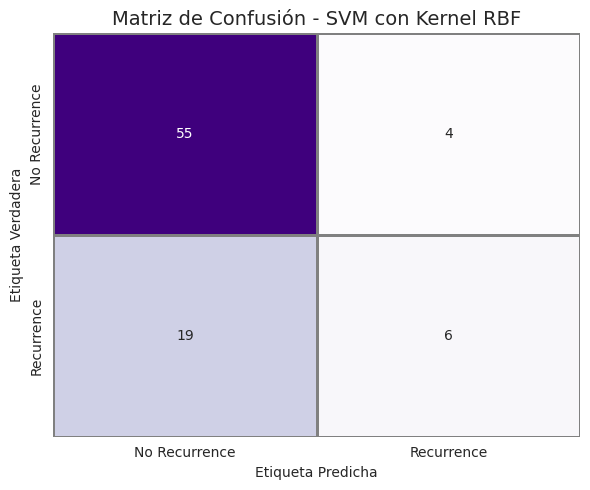

In [ ]:
svm_rbf = SVC(kernel='rbf', random_state=42)

svm_rbf.fit(X_train, y_train)

y_pred_svm = svm_rbf.predict(X_test)

print("\n Reporte de Clasificación:\n", classification_report(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm)
labels = ['No Recurrence', 'Recurrence']

plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples',
            xticklabels=labels, yticklabels=labels, cbar=False,
            linewidths=1, linecolor='gray')
plt.title('Matriz de Confusión - SVM con Kernel RBF', fontsize=14)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.tight_layout()
plt.show()

## Interpretación del modelo: SVM con Kernel RBF

### 1. Matriz de Confusión

|                  | Predicho: No Recurrence | Predicho: Recurrence |
|------------------|-------------------------|-----------------------|
| **Real: No Recurrence** | 55                      | 4                     |
| **Real: Recurrence**     | 19                      | 6                     |

- El modelo logra clasificar correctamente **55 de 59** casos de **no recurrencia**.
- Detecta **6 de 25** casos de **recurrencia** correctamente.
- Aunque aún hay 19 falsos negativos, la proporción de errores en clase 1 es menor que en los modelos anteriores.

---

### 2. Métricas clave

- **Clase 0 (No Recurrence)**
  - Precision: 55 / (55 + 19) ≈ 0.74
  - Recall: 55 / (55 + 4) ≈ 0.93

- **Clase 1 (Recurrence)**
  - Precision: 6 / (6 + 4) = 0.60
  - Recall: 6 / (6 + 19) ≈ 0.24

*Conclusión*: El modelo SVM logra **altísima sensibilidad (recall)** para la clase mayoritaria, pero aún tiene dificultades detectando con seguridad los casos de recurrencia. Sin embargo, **aumenta la precisión de la clase 1**, lo que indica que **cuando predice recurrencia, tiene más certeza** que los modelos anteriores.

---

### 3. Exactitud general

- **Accuracy total**: (55 + 6) / 84 = **72.6%**

Este es el **mejor accuracy general** de los tres modelos evaluados.

---

### Análisis de complejidad del modelo

El modelo SVM con kernel RBF presenta una **alta capacidad de modelado**, y su complejidad se describe así:

- Utiliza **fronteras de decisión no lineales** mediante funciones kernel, lo que le permite adaptarse a patrones más complejos.
- Es **robusto al sobreajuste** si los hiperparámetros `C` y `gamma` son bien ajustados.
- Su tiempo de entrenamiento puede ser mayor que en regresión o árboles, pero **sigue siendo aceptable para datasets pequeños** como este.
- Su interpretación **no es trivial** (es un modelo caja negra), pero su rendimiento puede justificarlo.

En resumen: el modelo SVM es el más sólido en cuanto a **rendimiento global**, aunque aún hay espacio de mejora en la detección de casos positivos (recurrencia). Su uso está totalmente justificado como el modelo **más potente del proyecto**.

#Comparación de Modelos Entrenados



| Modelo                   | Accuracy | Precision (Clase 1) | Recall (Clase 1) | F1-score (Clase 1) | Observaciones clave                                      |
|--------------------------|----------|----------------------|------------------|---------------------|-----------------------------------------------------------|
| Regresión Logística      | 70%      | 0.50                 | 0.32             | 0.39                | Simple, interpretable, pero débil con clase minoritaria   |
| Árbol de Decisión        | 69%      | 0.48                 | 0.40             | 0.44                | Capta no linealidades, mejora ligeramente la clase 1      |
| SVM (Kernel RBF)         | **72.6%**| **0.60**             | 0.24             | 0.34                | Mejor accuracy general, mayor precisión en recurrencia    |

---

### Conclusiones:

- El modelo más equilibrado en rendimiento general es **SVM**, especialmente en precisión.
- **Árbol de decisión** logra un balance intermedio sin requerir mucha configuración.
- **Regresión logística** sirve como modelo base, rápido y fácil de interpretar, pero limitado.
- Todos los modelos tienen dificultades detectando correctamente la clase minoritaria (recurrence-events), lo que puede abordarse en el futuro con técnicas de balanceo como SMOTE, o ajustando hiperparámetros.

